# **Myntra Fashion Search using Generative AI**

# <font color="Green">**Problem Statement**
Finding the right product online often feels harder than it should be — users know what they want, but search engines don’t always understand what they mean. Our solution bridges that gap by interpreting natural language queries, grasping user intent, and delivering context-aware product recommendations that feel genuinely personalized. Instead of just matching words, it understands meaning, relevance, and reasoning behind every suggestion.

# <font color="Green"/> **System Features**<font color="Black"/>

1. **RAG-Based Search**: Semantic search using vector embeddings
2. **Multiple Search Modes**:
   - Simple product search
   - Price range filtering
   - Brand-specific search
   - Top-rated products
3. **LangChain Agents**: Intelligent query routing and tool selection
4. **Conversational AI**: Natural language understanding and generation
5. **Persistent Storage**: ChromaDB vector database

# <font color="Green"> **1. Requried Libraries Installation and Import**

 <font color="Orange" />**1.1 Install Required Libraries**

In [1]:
!pip install langchain langchain-community langchain-openai
!pip install chromadb
!pip install sentence-transformers
!pip install openai
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.77
    Uninstalling langchain-core-0.3.77:
      Successfully uninstalled langchain-core-0.3.77
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is

<font color="Orange"> **1.2 Import Requried Libraries**

In [18]:
import numpy as np
import pandas as pd
import os
import time
import warnings
from typing import List, Dict, Any
warnings.filterwarnings('ignore')
from sentence_transformers import CrossEncoder

import langchain
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import TextLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain.chains import LLMChain
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from langchain.agents import create_react_agent, AgentExecutor
from langchain.tools import Tool
from langchain import hub
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

# <font color="Green"> **2: Load and Preprocess Data**

<font color="Orange"> **2.1 Read CSV DataSet**

In [4]:
df = pd.read_csv('fashion_ecommerce_dataset_600_records (1).csv')

<font color="Orange"> **2.2 Display Info**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Uniq Id                  600 non-null    object 
 1   Crawl Timestamp          600 non-null    object 
 2   Pageurl                  600 non-null    object 
 3   Pdp Url                  600 non-null    object 
 4   Product Id               600 non-null    int64  
 5   Product Name             600 non-null    object 
 6   List Price               600 non-null    int64  
 7   Sale Price               600 non-null    int64  
 8   Discount Percentage      600 non-null    int64  
 9   Brand                    600 non-null    object 
 10  Product Rank             600 non-null    float64
 11  Size                     600 non-null    int64  
 12  Availability             600 non-null    object 
 13  Product Description      600 non-null    object 
 14  Seller                   6

<font color="Orange"> **2.3 Filter Null Value Columns**

In [6]:
#  Identify missing columns
missing_summary = df.isnull().sum()
missing_percent = (missing_summary / len(df)) * 100

# Create a quick report
missing_report = pd.DataFrame({
    "Missing Count": missing_summary,
    "Missing %": missing_percent
}).sort_values(by="Missing %", ascending=False)

print("==  Missing Value Summary  ==")
print(missing_report[missing_report["Missing Count"] > 0])


==  Missing Value Summary  ==
                      Missing Count   Missing %
Best Seller Rank 2              600  100.000000
Sub Category 5                  600  100.000000
Darts                           600  100.000000
Date First Available            600  100.000000
Collar                          542   90.333333
Leg Style                       471   78.500000
Length                          466   77.666667
Fulfilled By                    405   67.500000
Rise Style                      400   66.666667
Closure                         342   57.000000
Neck                            260   43.333333
Sleeve Type                     260   43.333333
Sleeve Length                   260   43.333333
Sleeve                          260   43.333333
Best Seller Rank 1              168   28.000000


<font color="Orange"> **2.4 Drop Null Value Columns**

In [7]:
# Drop completely empty columns
drop_full_nulls = missing_report[missing_report["Missing %"] == 100].index.tolist()
df.drop(columns=drop_full_nulls, inplace=True)
print(f"\nDropped fully null columns: {drop_full_nulls}")


Dropped fully null columns: ['Best Seller Rank 2', 'Sub Category 5', 'Darts', 'Date First Available']


<font color="Orange"> **2.5 Compute Missing Values In Categorial and Numerical Columns**

In [8]:
# Impute categorical missing values with mode (group-wise)
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

# Impute numeric missing values with median
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

<font color="Orange"> **2.6 Validate Cleanup**

In [9]:
print("\n✅ Missing values after cleaning:")
print(df.isnull().sum().sum(), " total missing values remain.")


✅ Missing values after cleaning:
0  total missing values remain.


# <font color="Green">**3. Setup Open API**


In [10]:
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
api_key=os.getenv("OPENAI_API_KEY")

# <font color="Green"> **4. Generative AI Implementation FrameWork - LangChain**
LangChain stands out as a strong choice for this Retrieval-Augmented Generation (RAG) setup because it:

- Smoothly connects embeddings, vector databases, and large language models into one coherent system.

-  Offers modular “chains” and intelligent “agents” that make complex reasoning workflows easier to design.

-  Includes built-in retrieval tools that allow complete control over how prompts and responses are handled.

- Supports the creation of specialized search tools — such as filters for price, brand, or customer ratings.

- Provides ready-to-use, production-grade components that drastically cut development time, turning long build cycles into quick deployments.

The LangChain framework revolves around the following building blocks:
* Model I/O: Interface with language models (LLMs & Chat Models, Prompts, Output Parsers)
* Retrieval: Interface with application-specific data (Document loaders, Document transformers, Text embedding models, Vector stores, Retrievers)
* Chains: Construct sequences/chains of LLM calls
* Memory: Persist application state between runs of a chain
* Agents: Let chains choose which tools to use given high-level directives
* Callbacks: Log and stream intermediate steps of any chain

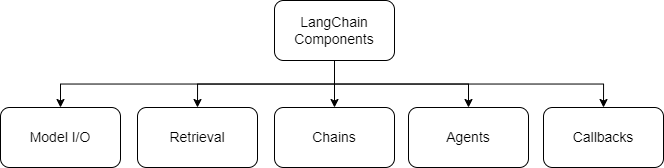

  ### <font color="Orange">**4.1 Create LangChain Document objects with rich product information.**


In [11]:

def generate_documents(df):
    documents = []

    for idx, row in df.iterrows():
        # Create comprehensive product text
        product_text = f"""
          Product: {row['Product Name']}
          Brand: {row['Brand']}
          Category: {row.get('Sub Category 1', 'General')}
          Price: ₹{row['Sale Price']} (Original: ₹{row['List Price']}, Discount: {row['Discount Percentage']}%)
          Color: {row['Color']}
          Rating: {row['Average Rating']}/5.0 ({row['Total Number Of Ratings']} ratings)
          Gender: {row.get('Gender', 'Unisex')}
          Description: {row['Product Description']}

          Additional Details:
          - Fit: {row.get('Fit', 'N/A')}
          - Fabric: {row.get('Fabric Or Material', 'N/A')}
          - Pattern: {row.get('Pattern', 'N/A')}
          - Length: {row.get('Length', 'N/A')}
          - Sleeve Length: {row.get('Sleeve Length', 'N/A')}
          - Availability: {row.get('Availability', 'Check website')}
          """

        # Create metadata for filtering
        metadata = {
            'product_id': str(row['Product Id']),
            'product_name': row['Product Name'],
            'brand': (row['Brand']).lower(),
            'sale_price': float(row['Sale Price']),
            'list_price': float(row['List Price']),
            'discount': float(row['Discount Percentage']),
            'rating': float(row['Average Rating']),
            'num_ratings': int(row['Total Number Of Ratings']),
            'color': row['Color'],
            'gender': row.get('Gender', 'Unisex'),
            'category': row.get('Sub Category 1', 'General'),
            'pdp_url': row.get('Pdp Url', ''),
        }

        doc = Document(page_content=product_text, metadata=metadata)
        documents.append(doc)

    print(f"Created {len(documents)} product documents")
    return documents

# Create documents
documents = generate_documents(df)
print(f"\nSample document:\n{documents[0].page_content}...")


Created 600 product documents

Sample document:

          Product: Raymond Navy Solid Casual Trousers
          Brand: Raymond
          Category: Trousers
          Price: ₹1264 (Original: ₹1642, Discount: 23%)
          Color: Navy
          Rating: 3.9/5.0 (890 ratings)
          Gender: Men
          Description: Professional trousers designed for the workplace. Premium fabric with wrinkle-resistant properties.

          Additional Details:
          - Fit: Slim
          - Fabric: Cotton
          - Pattern: Solid
          - Length: Knee Length
          - Sleeve Length: Short Sleeve
          - Availability: In Stock
          ...


### <font color="Orange"> **4.2 Generate Document Chunks**

In [12]:
CHUNK_SIZE=500
CHUNK_OVERLAP=50

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP
)
chunked_docs = text_splitter.split_documents(documents)

### <font color="Orange"> **4.3 Generate Vector Embeddings**

In [13]:
EMBEDDING_MODEL="text-embedding-3-small"

embeddings = OpenAIEmbeddings(
    model=EMBEDDING_MODEL,
    openai_api_key = os.environ['OPENAI_API_KEY']
)

/tmp/ipython-input-2325582985.py:3: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(


### <font color="Orange"> **4.4 Vector Store**

In [14]:
vector_embeddings = Chroma.from_documents(
    documents=chunked_docs,
    embedding=embeddings,
    persist_directory="./chroma_db"
)

print(f"VectorStore completed with {vector_embeddings._collection.count()} documents")

VectorStore completed with 1200 documents


### <font color="Orange"> **4.5 Crossencoder for Reranking**

In [15]:
# Using MS MARCO CrossEncoder - specifically trained for passage reranking
ENCODER_MODEL='cross-encoder/ms-marco-MiniLM-L-6-v2'
reranker = CrossEncoder(ENCODER_MODEL)

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

### <font color="Orange"> **4.6 ReRank Documents**

In [16]:
# Rerank documents using CrossEncoder for better relevance.
def rerank_documents(query: str, documents: List[Document], top_k: int = 5) -> List[Document]:

    if not documents:
        return documents

    # Prepare query-document pairs for CrossEncoder
    pairs = [[query, doc.page_content] for doc in documents]

    # Get relevance scores from CrossEncoder
    scores = reranker.predict(pairs)

    # Sort documents by scores (highest first)
    scored_docs = list(zip(documents, scores))
    scored_docs.sort(key=lambda x: x[1], reverse=True)

    # Return top_k documents
    reranked = [doc for doc, score in scored_docs[:top_k]]

    #print(f"Reranked {len(documents)} documents, returning top {len(reranked)}")
    return reranked

#<font color="Green"> **5. LLM Chat Model**

In [19]:
# Initialize LLM
LLM_MODEL="gpt-3.5-turbo"

llm = ChatOpenAI(
    model_name=LLM_MODEL,
    temperature=0.3,
    max_tokens=1000
)

#<font color="Green"> **6. Prompt Template**

In [20]:
# Custom prompt template
prompt_template = """
You are a seasoned fashion stylist and shopping advisor for Myntra, one of India’s top online fashion destinations.
Your role is to understand the shopper’s intent and provide thoughtful, personalized product recommendations using the information below.

Product Catalog:
{context}

Customer Query: {question}

Guidelines:
1. Interpret the customer’s preferences, context, and style requirements carefully.
2. Recommend the most relevant items from the given catalog. If multiple options fit well, list them all.
3. Justify why each suggestion suits the customer’s needs or preferences.
4. Include key details such as brand, price, discount, rating, and any standout attributes.
5. Where applicable, compare similar items to highlight differences or advantages.
6. Maintain a warm, conversational tone like a fashion expert assisting a shopper.
7. If no item perfectly fits, suggest the next best alternatives and explain why.

Your Response:
"""

PROMPT = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"]
)

#<font color="Green"> **7. Simple Search - RAG model using RetrievalQA Chain**

In [21]:
# Create a RetrievalQA chain for a RAG (Retrieval-Augmented Generation) setup.
# It uses the specified LLM and vectorstore retriever to fetch top-k similar documents,
# then applies the crossencoder to rerank the results
# then applies the "stuff" chain type with a custom prompt to answer user queries.

TOP_K_RESULTS = 10
# Create base retriever
base_retriever = vector_embeddings.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 10}  # Retrieve more initially, then rerank
)

# Create CrossEncoder reranker using LangChain's wrapper
model = HuggingFaceCrossEncoder(model_name="cross-encoder/ms-marco-MiniLM-L-6-v2")
compressor = CrossEncoderReranker(model=model, top_n=TOP_K_RESULTS)

# Create compression retriever with reranking
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=base_retriever
)

# Create enhanced RAG chain with reranking
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=compression_retriever,  # Use reranking retriever
    return_source_documents=True,
    chain_type_kwargs={"prompt": PROMPT}
)

print("Enhanced RAG chain with CrossEncoder reranking created successfully!")

Enhanced RAG chain with CrossEncoder reranking created successfully!


# <font color="Green">**8. Advanced Features: Semantic Similarity Search**

### <font color="Orange">8.1 Searches products within a given price range and keyword.

In [22]:
# Search products within a specific price range. -Format: 'min_price-max_price keyword' e.g., '500-2000 shirt'
def search_by_price_range(query: str) -> str:

    try:
        parts = query.split()

        price_range = parts[0].split('-')
        min_price = float(price_range[0])
        max_price = float(price_range[1])
        keyword = ' '.join(parts[1:])

        # Search with filter
        results = vector_embeddings.similarity_search(
            keyword,
            k=10,
            filter={
                "sale_price": {"$gte": min_price}
            }
        )
        results = [
                   r for r in results
                   if r.metadata.get("sale_price", 0) <= max_price
        ][:10]  # take top 10 after filtering

        if not results:
            return f"No products found in price range ₹{min_price}-₹{max_price}"

        # Rerank using CrossEncoder
        results = rerank_documents(keyword, results, top_k=5)

        response = f"Found {len(results)} products in range ₹{min_price}-₹{max_price}:\n\n"

        for doc in results[:5]:
            meta = doc.metadata
            response += f"• {meta['product_name']} - ₹{meta['sale_price']} (Rating: {meta['rating']}/5)\n"

        return response
    except Exception as e:

        return f"Error parsing price range. Use format: 'min-max keyword' e.g., '500-2000 shirt'"

### <font color="Orange">8.2 Searches products by brand name.

In [23]:
# Search products by specific brand. - Format: 'brand_name' e.g., 'Nike' or 'Roadster'
def search_by_brand(query: str) -> str:

    results = vector_embeddings.similarity_search(
        query,
        k=10,
        filter={"brand":query.lower()}
    )

    if not results:
        return f"No products found for brand: {query}"

    response = f"Found {len(results)} products from {query}:\n\n"
    for doc in results[:5]:
        meta = doc.metadata
        response += f"• {meta['product_name']} - ₹{meta['sale_price']} ({meta['discount']}% off)\n"

    return response

### <font color="Orange">8.3 Retrieves top-rated products for a query and sorts them by rating and number of ratings

In [24]:
# Search for top-rated products matching the query
def search_top_rated(query: str) -> str:

    results = vector_embeddings.similarity_search(query, k=30)

    # Rerank for relevance
    results = rerank_documents(query, results, top_k=20)

    # Sort by rating
    sorted_results = sorted(
        results,
        key=lambda x: (x.metadata.get('rating', 0), x.metadata.get('num_ratings', 0)),
        reverse=True
    )

    response = f"Top-rated products for '{query}':\n\n"
    for doc in sorted_results[:5]:
        meta = doc.metadata
        response += f"• {meta['product_name']} - {meta['rating']}/5 ({meta['num_ratings']} ratings) - ₹{meta['sale_price']}\n"

    return response

### <font color="Orange">8.4 Similar Search Products

In [25]:
# Define a function to find and display products similar to a given product name.
# Uses vector similarity search on the stored embeddings and prints key metadata
# Such as brand, price, rating, and discount for the top-k similar products.

def search_similar_product(product_name: str, k: int = 5) -> str:
    """
    First answers about the product using RAG,
    then recommends similar products from *different brands*.
    """

    # Step 1: Find base product info (to know its brand)
    base_results = vector_embeddings.similarity_search(product_name, k=1)
    if not base_results:
        return f"No product found for '{product_name}'"

    base_brand = base_results[0].metadata.get("brand", "").lower()

    # Step 2: Find similar products but exclude same brand
    results = vector_embeddings.similarity_search(product_name, k=20)  # fetch more, then filter

    filtered_results = [
        r for r in results if r.metadata.get("brand", "").lower() != base_brand
    ][:k]  # take top k after filtering

    # Step 3: Rerank all results
    filtered_results = rerank_documents(product_name, filtered_results, top_k=5)

    # Build response
    response = f" Products that are similar to '{product_name}' and of your interest from different brands:\n\n"
    if filtered_results:
        for i, doc in enumerate(filtered_results, 1):
            meta = doc.metadata
            response += (
                f"• {meta['product_name']} | Brand: {meta['brand']} | "
                f"₹{meta['sale_price']} | Rating: {meta['rating']}/5 "
                f"({meta['discount']}% off)\n"
            )
    else:
        response += "No alternative brand recommendations found."

    return response


# Example: Find similar products
similar = search_similar_product("nike air shoes", k=5)
print(similar)

 Products that are similar to 'nike air shoes' and of your interest from different brands:

• H&M Blue Colorblock Training Shoes | Brand: h&m | ₹2835.0 | Rating: 3.1/5 (25.0% off)
• H&M Blue Colorblock Running Shoes | Brand: h&m | ₹1265.0 | Rating: 3.6/5 (34.0% off)
• Adidas White Colorblock Sports Shoes | Brand: adidas | ₹640.0 | Rating: 3.6/5 (71.0% off)
• Reebok Navy Colorblock Casual Sneakers | Brand: reebok | ₹2789.0 | Rating: 4.7/5 (35.0% off)
• Zara Red Colorblock Running Shoes | Brand: zara | ₹705.0 | Rating: 4.6/5 (23.0% off)



### <font color="Orange">8.5 Search Tools Array according to preference

In [26]:
# Create tools
search_tools = [
    Tool(
        name="Similar Product Search",
        func=search_similar_product,
        description="Finds and directly returns a ready-to-display bulleted list of similar products with prices and ratings."
    ),
    Tool(
        name="Price Range Search",
        func=search_by_price_range,
        description="Search products within a price range. Input format: 'min_price-max_price keyword' (e.g 1000-2000 shirt)"
    ),
    Tool(
        name="Brand Search",
        func=search_by_brand,
        description="Search products by specific brand name. Input should be the brand name."
    ),
    Tool(
        name="Top Rated Search",
        func=search_top_rated,
        description="Find top-rated products for a category or type. Input should be the product type or category."
    )
]

# <font color="Green"> **9. ReAct agent**

With a ReAct agent, the LLM can dynamically:

- Decide which search tool to use (keyword, vector, or price-filtered).

- Combine reasoning with multiple actions (e.g., search → rerank → summarize).

- Generate conversational and contextually rich answers.

This makes your system much more intelligent, autonomous, and scalable — ideal for a real-world fashion assistant or product recommender.

In [27]:
# Create a ReAct agent using the specified LLM and the custom search tools.
# The agent uses a prompt from the hub and can interact with the tools to answer queries.
# AgentExecutor wraps the agent for execution with verbose output, error handling, and limited iterations.

# Get base ReAct prompt
base_prompt = hub.pull("hwchase17/react")

# Customize it
custom_template = base_prompt.template + """

IMPORTANT:
- If the tool returns a formatted bulleted list or ready-to-display answer,
  keep the format and details same but add short summary that match the user requirement.
"""

agent_prompt = PromptTemplate(
    input_variables=base_prompt.input_variables,
    template=custom_template
)

search_agent = create_react_agent(
    llm=llm,
    tools=search_tools,
    prompt=agent_prompt
)

search_agent_executor = AgentExecutor(
    agent=search_agent,
    tools=search_tools,
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=5
)

print("Agent created successfully!")

Agent created successfully!


### <font color="Orange">9.1 Product Comparison using Langchain Agent


In [28]:
# Compare products based on brand, price, rating, and discount. Expects query like 'Compare Nike and Adidas'.
def compare_products(query: str) -> str:

    try:
        #return query
        # Extract brands from query (simple split on "and")
        brands = [b.strip().strip("'") for b in query.lower().replace("compare ", "").split("and")]

        if len(brands) < 2:
            return "Please provide at least two brands to compare."

        responses = []
        for brand in brands:
            results = vector_embeddings.similarity_search(
                brand,
                k=5,
                filter={"brand": brand.lower()}
            )
            if not results:
                responses.append(f"No products found for {brand.title()}")
                continue

            avg_price = sum(r.metadata.get("sale_price", 0) for r in results) / len(results)
            avg_rating = sum(r.metadata.get("rating", 0) for r in results) / len(results)
            responses.append(
                f"{brand.title()}: Avg Price ₹{avg_price:.2f}, Avg Rating {avg_rating:.2f}/5"
            )

        comparison = "\n".join(responses)
        return f"Comparison results:\n{comparison}"

    except Exception as e:
        return f"Error comparing products: {str(e)}"

In [29]:
compare_tool = Tool(
    name="Compare Products",
    func=compare_products,
    description="Compare products between brands and Output the comparison elements with details. Input format: 'Compare Brand1 and Brand2' eg. Compare Nike and Adidas. "
)

In [30]:
# Create a ReAct agent using the specified LLM and the custom search tools.
# The agent uses a prompt from the hub and can interact with the tools to answer queries.
# AgentExecutor wraps the agent for execution with verbose output, error handling, and limited iterations.

agent_prompt = hub.pull("hwchase17/react")

compare_agent = create_react_agent(
    llm=llm,
    tools=[compare_tool],
    prompt=agent_prompt
)

compare_agent_executor = AgentExecutor(
    agent=compare_agent,
    tools=[compare_tool],
    verbose=True,
    handle_parsing_errors=True,
    max_iterations=5
)

print("Agent created successfully!")

Agent created successfully!


# <font color="Green"> **10. Search Functions**

In [31]:
# Perform a simple RAG search without agent
def simple_search(query: str) -> Dict[str, Any]:

    result = qa_chain.invoke({"query": query})

    print("\n" + "="*50)
    print("PRODUCT RECOMMENDATIONS")
    print("="*50)
    print(f"\nQuery: {query}\n")
    print(result["result"])
    print("\n" + "="*50)
    print(f"Retrieved {len(result['source_documents'])} relevant products")
    print("="*50)

    return result

# Perform an advanced search using the agent.
def agent_search(query: str) -> str:

    result = search_agent_executor.invoke({"input": query})

    print("\n" + "="*50)
    print("SEARCH AGENT RECOMMENDATION")
    print("="*50)
    print(f"\nQuery: {query}\n")
    print(result["output"])
    print("\n" + "="*50)

    return result["output"]

# Perform an product comparison using the agent.
def agent_compare_product(query: str) -> str:

    result = compare_agent_executor.invoke({"input": query})

    print("\n" + "="*50)
    print("COMPARE AGENT RECOMMENDATION")
    print("="*50)
    print(f"\nQuery: {query}\n")
    print(result["output"])
    print("\n" + "="*50)

    return result["output"]

# <font color="Green"> **11. Search Examples**

In [32]:
# Simple product search
query1 = "I need a formal shirt for office wear under ₹1500"
result1 = simple_search(query1)


PRODUCT RECOMMENDATIONS

Query: I need a formal shirt for office wear under ₹1500

Hello! I understand you're looking for a formal shirt for office wear under ₹1500. Let me help you find the perfect option from our catalog.

1. Flying Machine Light Blue Checked Solid Shirt
   - Brand: Flying Machine
   - Price: ₹1268 (Original: ₹2307, Discount: 45%)
   - Rating: 5.0/5.0 (2903 ratings)
   - This shirt not only fits your budget but also offers a substantial discount. The light blue color adds a touch of sophistication, and the impeccable tailoring ensures a sharp look for the office.

2. Pepe Jeans Blue Striped Checked Shirt
   - Brand: Pepe Jeans
   - Price: ₹1072 (Original: ₹2979, Discount: 64%)
   - Rating: 4.2/5.0 (1175 ratings)
   - This shirt is a steal with a 64% discount. The blue stripes add a subtle yet stylish element to your office attire, and the premium cotton fabric guarantees comfort all day long.

3. Reebok Light Blue Checked Formal Shirt
   - Brand: Reebok
   - Price: 

In [33]:
# Example 2: Brand-specific search
query2 = "Show me H&M dresses"
result2 = simple_search(query2)


PRODUCT RECOMMENDATIONS

Query: Show me H&M dresses

Hello! I see you're interested in H&M dresses, so let me help you find the perfect one for your style. 

Based on your preference for H&M dresses, I have a few options that I think you'll love:

1. H&M Black Striped Midi Dress:
   - Price: ₹862 (Original: ₹2397, Discount: 64%)
   - Rating: 4.7/5.0 (4072 ratings)
   - Description: This contemporary black midi dress is ideal for parties and celebrations. The quality fabric drapes beautifully, making it a stylish and comfortable choice.

2. H&M Blue Striped Mini Dress:
   - Price: ₹3085 (Original: ₹4227, Discount: 27%)
   - Rating: 4.3/5.0 (2631 ratings)
   - Description: If you're looking for a stunning dress for special occasions, this blue mini dress is perfect. It features a flowing silhouette and comfortable fabric for a chic look.

3. H&M Purple Striped Shift Dress:
   - Price: ₹2397 (Original: ₹3284, Discount: 27%)
   - Rating: 3.4/5.0 (2701 ratings)
   - Description: For timele

In [34]:
query3 = "I want a comfortable cotton t-shirt with good ratings"
result3 = simple_search(query3)


PRODUCT RECOMMENDATIONS

Query: I want a comfortable cotton t-shirt with good ratings

Hello there! I see you're looking for a comfortable cotton t-shirt with good ratings. Based on your preferences, I have some fantastic recommendations for you from our catalog.

1. Allen Solly Blue Graphic Polo T-Shirt:
   - Brand: Allen Solly
   - Price: ₹612 (Original: ₹1801, Discount: 66%)
   - Rating: 4.7/5.0 (4854 ratings)
   - Description: This classic t-shirt not only offers maximum comfort but also boasts an impressive rating of 4.7 out of 5. The discounted price of ₹612 makes it a steal!

2. Nike Blue Graphic V-Neck T-Shirt:
   - Brand: Nike
   - Price: ₹1395 (Original: ₹2083, Discount: 33%)
   - Rating: 4.5/5.0 (1959 ratings)
   - Description: Another top pick with a high rating of 4.5 out of 5, this t-shirt from Nike is designed for ultimate comfort and style. The V-neck adds a trendy touch to your casual look.

3. Raymond Blue Printed Polo T-Shirt:
   - Brand: Raymond
   - Price: ₹637 (O

In [35]:
query4 = "Find me the best rated shirt in range of 1000 to 2000 and 4 star rating"
result4 = agent_search(query4)



> Entering new AgentExecutor chain...
Action: Price Range Search
Action Input: 1000-2000 shirtFound 2 products in range ₹1000.0-₹2000.0:

• Calvin Klein Green Striped Sports T-Shirt - ₹1535.0 (Rating: 3.3/5)
• Nike Grey Solid Training Top - ₹1205.0 (Rating: 4.0/5)
Final Answer: The best rated shirt in the range of 1000 to 2000 with a 4-star rating is the Nike Grey Solid Training Top priced at ₹1205.0.

> Finished chain.

SEARCH AGENT RECOMMENDATION

Query: Find me the best rated shirt in range of 1000 to 2000 and 4 star rating

The best rated shirt in the range of 1000 to 2000 with a 4-star rating is the Nike Grey Solid Training Top priced at ₹1205.0.



In [36]:
query5 = "Compare Arrow and Fabindia products"
result5 = agent_compare_product(query5)



> Entering new AgentExecutor chain...
I should use the Compare Products tool to compare the products of Arrow and Fabindia.
Action: Compare Products
Action Input: 'Compare Arrow and Fabindia'Comparison results:
Arrow: Avg Price ₹631.60, Avg Rating 4.38/5
Fabindia: Avg Price ₹1407.60, Avg Rating 4.10/5I now know the final answer
Final Answer: Arrow products have a lower average price and higher average rating compared to Fabindia products.

> Finished chain.

COMPARE AGENT RECOMMENDATION

Query: Compare Arrow and Fabindia products

Arrow products have a lower average price and higher average rating compared to Fabindia products.



# <font color="Green"> **12. Performance Metrics**

In [37]:
# Compare search results with and without CrossEncoder reranking.
def compare_reranking_performance(test_queries: List[str]):

    results = []

    for query in test_queries:
        print(f"\nTesting query: {query}")
        print("-" * 60)

        # Without reranking (basic similarity search)
        start = time.time()
        basic_results = vector_embeddings.similarity_search(query, k=5)
        basic_time = time.time() - start

        # With reranking
        start = time.time()
        initial_results = vector_embeddings.similarity_search(query, k=20)
        reranked_results = rerank_documents(query, initial_results, top_k=5)
        rerank_time = time.time() - start

        print(f"Basic search time: {basic_time:.3f}s")
        print(f"Reranking time: {rerank_time:.3f}s")
        print(f"\nTop result (basic): {basic_results[0].metadata['product_name']}")
        print(f"Top result (reranked): {reranked_results[0].metadata['product_name']}")

        results.append({
            'query': query,
            'basic_time': basic_time,
            'rerank_time': rerank_time,
            'basic_top': basic_results[0].metadata['product_name'],
            'rerank_top': reranked_results[0].metadata['product_name']
        })

    return pd.DataFrame(results)

# Test queries
rerank_test_queries = [
    "cotton shirt for summer",
    "formal office wear for men",
    "sports shoes for running"
]

comparison_df = compare_reranking_performance(rerank_test_queries)
comparison_df


Testing query: cotton shirt for summer
------------------------------------------------------------
Basic search time: 0.195s
Reranking time: 1.307s

Top result (basic): Pepe Jeans White Striped Printed Shirt
Top result (reranked): Highlander Light Blue Printed Printed Shirt

Testing query: formal office wear for men
------------------------------------------------------------
Basic search time: 0.212s
Reranking time: 1.348s

Top result (basic): Park Avenue Navy Checked Formal Trousers
Top result (reranked): Allen Solly Beige Striped Checked Shirt

Testing query: sports shoes for running
------------------------------------------------------------
Basic search time: 0.164s
Reranking time: 0.837s

Top result (basic): Nike Navy Solid Running Shoes
Top result (reranked): Puma White Solid Sports Shoes


,query,basic_time,rerank_time,basic_top,rerank_top
0,cotton shirt for summer,0.194802,1.307387,Pepe Jeans White Striped Printed Shirt,Highlander Light Blue Printed Printed Shirt
1,formal office wear for men,0.212242,1.347606,Park Avenue Navy Checked Formal Trousers,Allen Solly Beige Striped Checked Shirt
2,sports shoes for running,0.163560,0.836889,Nike Navy Solid Running Shoes,Puma White Solid Sports Shoes
